In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
#read this csv file /Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/commodity.csv
commodity = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/commodity.csv')

#/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/EHI640_returns10-02-2025.csv
benchmark_volatility = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/EHI640_returns10-02-2025.csv')

#/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/equity.csv
equity = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/equity.csv')

#/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/fixed_income.csv
fixed_income = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/fixed_income.csv')

#/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/gold.csv
gold = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/gold.csv')

#/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/volatility-daily.csv
volatility_daily = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/volatility-daily.csv')

#read this csv file /Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/volatility-monthly.csv
volatility_monthly = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/volatility-monthly.csv')

vix = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/dragon-portfolio/vix_data.csv')
#drop the first two rows of vix
vix = vix.iloc[2:]
#rename the Price column to Dates
vix = vix.rename(columns = {'Price':'Dates'})

#rename the Close column to VIX
vix = vix.rename(columns = {'Close':'VIX'})




In [3]:
equity.tail()


,Dates,SPXT Index,SPY US Equity,IVV US Equity,VOO US Equity,URTH US Equity,ACWI US Equity
6284,03/02/2025,13171.21,597.77,600.68,549.70,159.37,120.21
6285,04/02/2025,13266.45,601.78,604.69,553.35,160.64,121.30
6286,05/02/2025,13318.43,604.22,607.17,555.62,161.55,121.89
6287,06/02/2025,13366.96,606.32,609.40,557.62,162.06,122.31
6288,07/02/2025,13241.34,600.77,603.80,552.20,160.60,121.33


In [4]:
# 1. Ensure Dates are properly formatted
equity['Dates'] = pd.to_datetime(equity['Dates'], dayfirst=True)
equity = equity.sort_values(by='Dates')

# 2. Compute daily returns for all columns without dropping rows
equity_returns = equity.set_index('Dates').pct_change()

# 3. Keep only rows where the benchmark ('SPXT Index') has data
equity_returns_filtered = equity_returns[equity_returns['SPXT Index'].notna()]

# 4. Assign dependent variable (benchmark) and independent variables (proxies)
y = equity_returns_filtered['SPXT Index']
X = equity_returns_filtered.drop(columns=['SPXT Index'])  # Proxies

# 5. Compute R² values for each proxy
r2_scores = {}

for column in X.columns:
    valid_rows = X[column].notna()  # Select only non-NaN rows for this proxy
    X_column = X[column][valid_rows]
    y_valid = y[valid_rows]

    if len(y_valid) > 1:  # Ensure enough data points for regression
        X_const = sm.add_constant(X_column)
        model = sm.OLS(y_valid, X_const).fit()
        r2_scores[column] = model.rsquared

# 6. Sort and display R² values in descending order
sorted_r2 = sorted(r2_scores.items(), key=lambda item: item[1], reverse=True)

print("R² values of each proxy in descending order:")
for proxy, r2 in sorted_r2:
    print(f"{proxy}: {r2}")

# 7. Identify the best proxy
if sorted_r2:
    best_proxy, best_r2 = sorted_r2[0]
    print(f"\nBest proxy: {best_proxy} with R²: {best_r2}")
else:
    print("\nNo valid proxy found due to insufficient data.")




R² values of each proxy in descending order:
VOO US Equity: 0.9944279318696994
IVV US Equity: 0.9853267853010876
SPY US Equity: 0.9791806043147321
ACWI US Equity: 0.924011942683496
URTH US Equity: 0.7682170921252383

Best proxy: VOO US Equity with R²: 0.9944279318696994


                            OLS Regression Results                            
Dep. Variable:             SPXT Index   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 4.221e+05
Date:                Sun, 16 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:22:15   Log-Likelihood:                 32216.
No. Observations:                6288   AIC:                        -6.443e+04
Df Residuals:                    6286   BIC:                        -6.441e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           7.37e-05   1.82e-05      4.053

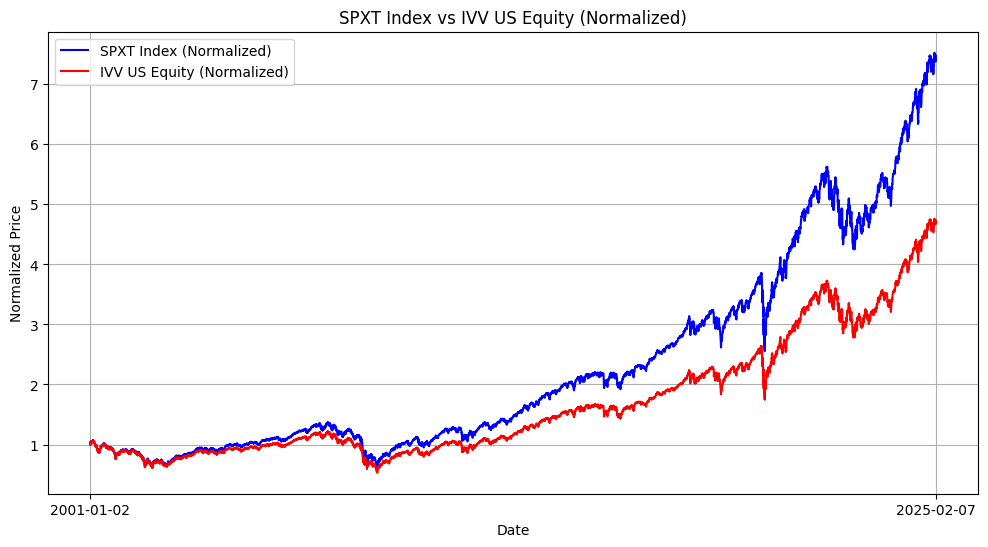

In [5]:
# 1. Ensure Dates are properly formatted
equity['Dates'] = pd.to_datetime(equity['Dates'], dayfirst=True)
equity = equity.sort_values(by='Dates')

best_proxy = 'IVV US Equity'

# 2. Keep only relevant columns: benchmark (SPXT Index) and best proxy (SPY US Equity)
equity_filtered = equity[['Dates', 'SPXT Index', best_proxy]].dropna()

# 3. Compute daily returns for both columns
equity_returns = equity_filtered.set_index('Dates').pct_change().dropna()

# 4. Assign dependent variable (benchmark) and independent variables (proxy)
y = equity_returns['SPXT Index']  # Benchmark returns
X = equity_returns[best_proxy]  # Best proxy returns

# 5. Add constant (intercept) to the independent variable
X_const = sm.add_constant(X)

# 6. Fit the regression model
model = sm.OLS(y, X_const).fit()

# 7. Print regression summary
print(model.summary())

# 8. Normalize prices for visualization (adjust to common scale)
equity_filtered[['SPXT Index', best_proxy]] = equity_filtered[['SPXT Index', best_proxy]].apply(lambda x: x / x.iloc[0])

# 9. Plot normalized prices over time
plt.figure(figsize=(12, 6))
plt.plot(equity_filtered['Dates'], equity_filtered['SPXT Index'], label="SPXT Index (Normalized)", color='blue')
plt.plot(equity_filtered['Dates'], equity_filtered[best_proxy], label="IVV US Equity (Normalized)", color='red')

# Simplify x-axis: show only first and last date
plt.xticks([equity_filtered['Dates'].iloc[0], equity_filtered['Dates'].iloc[-1]], rotation=0)
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.title("SPXT Index vs IVV US Equity (Normalized)")
plt.legend()
plt.grid()
plt.show()




In [6]:
fixed_income.tail()

,Dates,LT11TRUU Index,IEF US Equity,BND US Equity,AGG US Equity,TLH US Equity,ZROZ US Equity,GOVT US Equity,VGLT US Equity,TLT US Equity,GOVI US Equity,TLTW US Equity
6289,10/02/2025,577.55,93.12,72.36,97.49,101.24,69.88,22.585,56.31,89.00,27.35,23.59
6290,11/02/2025,573.87,92.88,72.24,97.27,100.70,69.27,22.550,55.98,88.43,27.25,23.58
6291,12/02/2025,566.16,92.24,71.87,96.76,99.53,67.82,22.430,55.26,87.23,27.00,23.44
6292,13/02/2025,575.11,92.93,72.30,97.34,100.81,69.57,22.555,56.08,88.68,27.27,23.64
6293,14/02/2025,578.37,93.32,72.53,97.70,101.40,70.06,22.625,56.42,89.15,27.39,23.70


In [7]:
# 1. Ensure Dates are properly formatted
fixed_income['Dates'] = pd.to_datetime(fixed_income['Dates'], dayfirst=True)
fixed_income = fixed_income.sort_values(by='Dates')

# 2. Compute daily returns for all columns without dropping rows
fixed_income_returns = fixed_income.set_index('Dates').pct_change()

# 3. Keep only rows where the benchmark ('LT11TRUU Index') has data
fixed_income_returns_filtered = fixed_income_returns[fixed_income_returns['LT11TRUU Index'].notna()]

# 4. Assign dependent variable (benchmark) and independent variables (proxies)
y = fixed_income_returns_filtered['LT11TRUU Index']
X = fixed_income_returns_filtered.drop(columns=['LT11TRUU Index'])  # Proxies

# 5. Compute R² values for each proxy
r2_scores = {}

for column in X.columns:
    valid_rows = X[column].notna()  # Select only non-NaN rows for this proxy
    X_column = X[column][valid_rows]
    y_valid = y[valid_rows]

    if len(y_valid) > 1:  # Ensure enough data points for regression
        X_const = sm.add_constant(X_column)
        model = sm.OLS(y_valid, X_const).fit()
        r2_scores[column] = model.rsquared

# 6. Sort and display R² values in descending order
sorted_r2 = sorted(r2_scores.items(), key=lambda item: item[1], reverse=True)

print("R² values of each proxy in descending order:")
for proxy, r2 in sorted_r2:
    print(f"{proxy}: {r2}")

# 7. Identify the best proxy
if sorted_r2:
    best_proxy, best_r2 = sorted_r2[0]
    print(f"\nBest proxy: {best_proxy} with R²: {best_r2}")
else:
    print("\nNo valid proxy found due to insufficient data.")


R² values of each proxy in descending order:
TLT US Equity: 0.9092214592339198
VGLT US Equity: 0.9025634375101477
ZROZ US Equity: 0.8940049206987192
GOVI US Equity: 0.8722000180917255
TLH US Equity: 0.8649381842284714
IEF US Equity: 0.7595725099328603
GOVT US Equity: 0.7458510044887863
TLTW US Equity: 0.7116849656852623
BND US Equity: 0.49505485721453546
AGG US Equity: 0.45399665008779955

Best proxy: TLT US Equity with R²: 0.9092214592339198


                            OLS Regression Results                            
Dep. Variable:         LT11TRUU Index   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 5.892e+04
Date:                Sun, 16 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:22:15   Log-Likelihood:                 26519.
No. Observations:                5885   AIC:                        -5.303e+04
Df Residuals:                    5883   BIC:                        -5.302e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001   3.48e-05      3.874

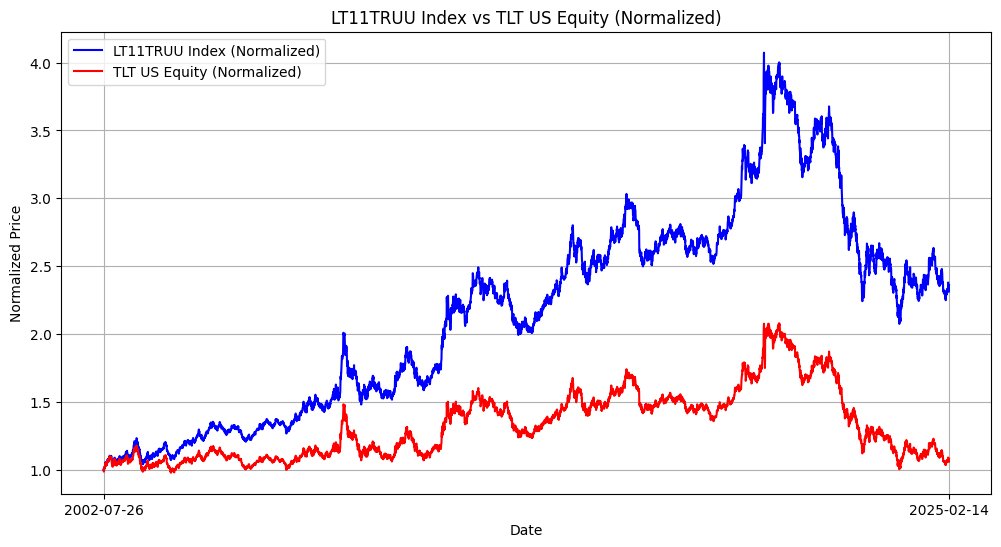

In [8]:
# 1. Ensure Dates are properly formatted
fixed_income['Dates'] = pd.to_datetime(fixed_income['Dates'], dayfirst=True)
fixed_income = fixed_income.sort_values(by='Dates')

best_proxy = 'TLT US Equity'

# 2. Keep only relevant columns: benchmark (SPXT Index) and best proxy (SPY US Equity)
fixed_income_filtered = fixed_income[['Dates', 'LT11TRUU Index', best_proxy]].dropna()

# 3. Compute daily returns for both columns
fixed_income_returns = fixed_income_filtered.set_index('Dates').pct_change().dropna()

# 4. Assign dependent variable (benchmark) and independent variables (proxy)
y = fixed_income_returns['LT11TRUU Index']  # Benchmark returns
X = fixed_income_returns[best_proxy]  # Best proxy returns

# 5. Add constant (intercept) to the independent variable
X_const = sm.add_constant(X)

# 6. Fit the regression model
model = sm.OLS(y, X_const).fit()

# 7. Print regression summary
print(model.summary())

# 8. Normalize prices for visualization (adjust to common scale)
fixed_income_filtered[['LT11TRUU Index', best_proxy]] = fixed_income_filtered[['LT11TRUU Index', best_proxy]].apply(lambda x: x / x.iloc[0])

# 9. Plot normalized prices over time
plt.figure(figsize=(12, 6))
plt.plot(fixed_income_filtered['Dates'], fixed_income_filtered['LT11TRUU Index'], label="LT11TRUU Index (Normalized)", color='blue')
plt.plot(fixed_income_filtered['Dates'], fixed_income_filtered[best_proxy], label="TLT US Equity (Normalized)", color='red')

# Simplify x-axis: show only first and last date
plt.xticks([fixed_income_filtered['Dates'].iloc[0], fixed_income_filtered['Dates'].iloc[-1]], rotation=0)
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.title("LT11TRUU Index vs TLT US Equity (Normalized)")
plt.legend()
plt.grid()
plt.show()

In [9]:
gold.tail()

,Dates,GOLDLNPM Index,GLD US Equity,IAU US Equity,PHYS US Equity,XAU Curncy,SGOL US Equity,OUNZ US Equity,BAR US Equity
6289,10/02/2025,2904.45,268.37,54.88,22.45,2908.26,27.75,28.06,28.68
6290,11/02/2025,2895.40,267.39,54.69,22.42,2897.91,27.65,27.95,28.60
6291,12/02/2025,2891.50,267.67,54.75,22.45,2904.04,27.69,28.00,28.64
6292,13/02/2025,2915.30,270.31,55.28,22.68,2928.21,27.96,28.25,28.91
6293,14/02/2025,2921.25,266.29,54.46,22.33,2882.53,27.54,27.83,28.48


In [10]:
# Ensure Dates are properly formatted
gold['Dates'] = pd.to_datetime(gold['Dates'], dayfirst=True)
gold = gold.sort_values(by='Dates')

# Define benchmark and proxies
benchmark = 'GOLDLNPM Index'
proxies = ['GLD US Equity', 'IAU US Equity', 'PHYS US Equity', 'XAU Curncy', 
           'SGOL US Equity', 'OUNZ US Equity', 'BAR US Equity']

# Function to run regressions and find the best proxy
def find_best_proxy(gold, benchmark, proxies):
    results = {}

    for proxy in proxies:
        # Drop NaNs to avoid errors
        temp_df = gold[[benchmark, proxy]].dropna()

        # Ensure we have enough data points
        if temp_df.shape[0] < 30:  # Require at least 30 observations
            continue
        
        # Define independent (X) and dependent (Y) variables
        X = temp_df[proxy].values.reshape(-1, 1)  # Reshape to 2D (required for regression)
        X = sm.add_constant(X)  # Add constant for intercept
        Y = temp_df[benchmark]
        
        # Run regression
        model = sm.OLS(Y, X).fit()
        results[proxy] = model.rsquared  # Store R² score

    # Find best proxy
    if results:
        best_proxy = max(results, key=results.get)
        best_r2 = results[best_proxy]
        return results, best_proxy, best_r2
    else:
        return None, None, None

# Find best proxy for gold
results, best_proxy, best_r_squared = find_best_proxy(gold, benchmark, proxies)

# Print all R² values
if results:
    print("\n📊 R² values for all proxies:")
    for proxy, r_squared in results.items():
        print(f"{proxy}: {r_squared:.4f}")

    # Print best proxy
    print(f"\n📌 Best Proxy = {best_proxy} (R² = {best_r_squared:.4f})")
else:
    print("No valid proxy found")




📊 R² values for all proxies:
GLD US Equity: 0.9978
IAU US Equity: 0.9989
PHYS US Equity: 0.9638
XAU Curncy: 0.9998
SGOL US Equity: 0.9968
OUNZ US Equity: 0.9993
BAR US Equity: 0.9993

📌 Best Proxy = XAU Curncy (R² = 0.9998)


                            OLS Regression Results                            
Dep. Variable:         GOLDLNPM Index   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     3814.
Date:                Sun, 16 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:22:16   Log-Likelihood:                 21244.
No. Observations:                6293   AIC:                        -4.248e+04
Df Residuals:                    6291   BIC:                        -4.247e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.607      0.1

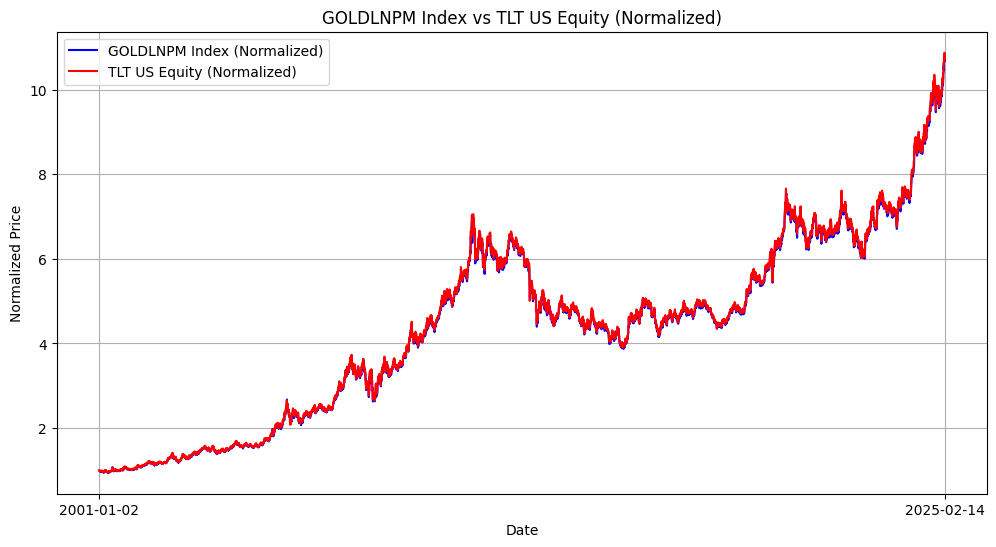

In [11]:
# 1. Ensure Dates are properly formatted
gold['Dates'] = pd.to_datetime(gold['Dates'], dayfirst=True)
gold = gold.sort_values(by='Dates')

best_proxy = 'XAU Curncy'

# 2. Keep only relevant columns: benchmark (SPXT Index) and best proxy (SPY US Equity)
gold_filtered = gold[['Dates', 'GOLDLNPM Index', best_proxy]].dropna()

# 3. Compute daily returns for both columns
gold_returns = gold_filtered.set_index('Dates').pct_change().dropna()

# 4. Assign dependent variable (benchmark) and independent variables (proxy)
y = gold_returns['GOLDLNPM Index']  # Benchmark returns
X = gold_returns[best_proxy]  # Best proxy returns

# 5. Add constant (intercept) to the independent variable
X_const = sm.add_constant(X)

# 6. Fit the regression model
model = sm.OLS(y, X_const).fit()

# 7. Print regression summary
print(model.summary())

# 8. Normalize prices for visualization (adjust to common scale)
gold_filtered[['GOLDLNPM Index', best_proxy]] = gold_filtered[['GOLDLNPM Index', best_proxy]].apply(lambda x: x / x.iloc[0])

# 9. Plot normalized prices over time
plt.figure(figsize=(12, 6))
plt.plot(gold_filtered['Dates'], gold_filtered['GOLDLNPM Index'], label="GOLDLNPM Index (Normalized)", color='blue')
plt.plot(gold_filtered['Dates'], gold_filtered[best_proxy], label="TLT US Equity (Normalized)", color='red')

# Simplify x-axis: show only first and last date
plt.xticks([gold_filtered['Dates'].iloc[0], gold_filtered['Dates'].iloc[-1]], rotation=0)
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.title("GOLDLNPM Index vs TLT US Equity (Normalized)")
plt.legend()
plt.grid()
plt.show()

In [12]:
commodity.tail()

,Dates,BCOM Index,DJP US Equity,DBC US Equity,GSG US Equity,XCMC LN Equity,BCOMF3T Index,ICOM LN Equity,WCOG LN Equity
6284,03/02/2025,103.7836,34.04,22.14,22.65,11.549,717.5864,7.2763,1073.25
6285,04/02/2025,104.2114,34.18,22.20,22.67,11.588,721.9846,7.2950,1065.50
6286,05/02/2025,104.1595,34.21,22.06,22.54,11.577,721.8993,7.2888,1064.75
6287,06/02/2025,104.3296,34.29,22.07,22.46,11.615,723.2375,7.3038,1074.50
6288,07/02/2025,104.2236,34.30,22.08,22.50,11.632,723.3181,7.3175,1078.75


In [13]:
# 1. Ensure Dates are properly formatted
commodity['Dates'] = pd.to_datetime(commodity['Dates'], dayfirst=True)
commodity = commodity.sort_values(by='Dates')

# 2. Compute daily returns for all columns without dropping rows
commodity_returns = commodity.set_index('Dates').pct_change()

# 3. Keep only rows where the benchmark ('BCOM Index') has data
commodity_returns_filtered = commodity_returns[commodity_returns['BCOM Index'].notna()]

# 4. Assign dependent variable (benchmark) and independent variables (proxies)
y = commodity_returns_filtered['BCOM Index']
X = commodity_returns_filtered.drop(columns=['BCOM Index'])  # Proxies

# 5. Compute R² values for each proxy
r2_scores = {}

for column in X.columns:
    valid_rows = X[column].notna()  # Select only non-NaN rows for this proxy
    X_column = X[column][valid_rows]
    y_valid = y[valid_rows]

    if len(y_valid) > 1:  # Ensure enough data points for regression
        X_const = sm.add_constant(X_column)
        model = sm.OLS(y_valid, X_const).fit()
        r2_scores[column] = model.rsquared

# 6. Sort and display R² values in descending order
sorted_r2 = sorted(r2_scores.items(), key=lambda item: item[1], reverse=True)

print("R² values of each proxy in descending order:")
for proxy, r2 in sorted_r2:
    print(f"{proxy}: {r2}")

# 7. Identify the best proxy
if sorted_r2:
    best_proxy, best_r2 = sorted_r2[0]
    print(f"\nBest proxy: {best_proxy} with R²: {best_r2}")
else:
    print("\nNo valid proxy found due to insufficient data.")




R² values of each proxy in descending order:
BCOMF3T Index: 0.9725152126540604
DJP US Equity: 0.9252799578501477
DBC US Equity: 0.7669230367722829
ICOM LN Equity: 0.7231114872604296
GSG US Equity: 0.7160037476614294
XCMC LN Equity: 0.5581401690054827
WCOG LN Equity: 0.3098163172003503

Best proxy: BCOMF3T Index with R²: 0.9725152126540604


                            OLS Regression Results                            
Dep. Variable:             BCOM Index   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 6.032e+04
Date:                Sun, 16 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:22:16   Log-Likelihood:                 21788.
No. Observations:                4873   AIC:                        -4.357e+04
Df Residuals:                    4871   BIC:                        -4.356e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.128e-05   3.96e-05     -1.041

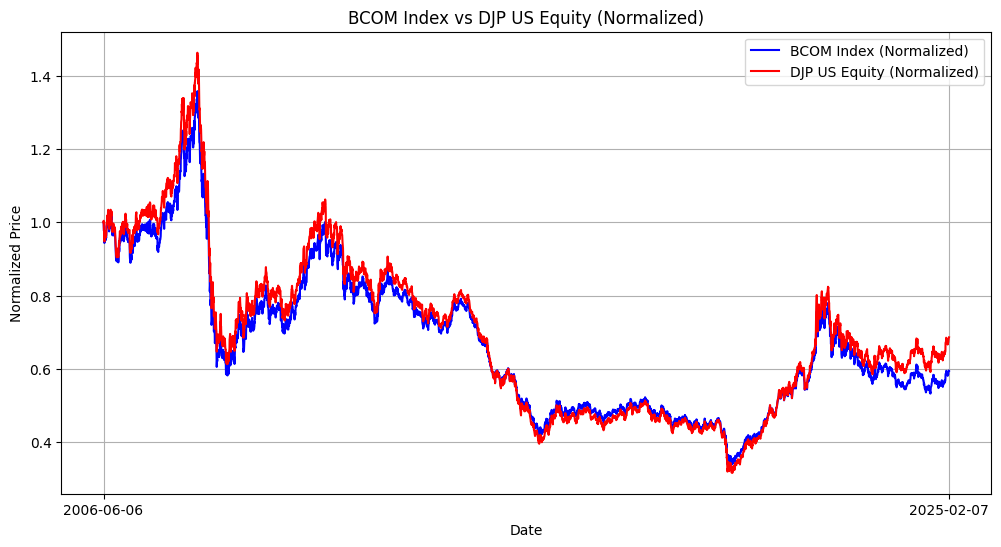

In [14]:
# 1. Ensure Dates are properly formatted
commodity['Dates'] = pd.to_datetime(commodity['Dates'], dayfirst=True)
commodity = commodity.sort_values(by='Dates')

best_proxy = 'DJP US Equity'

# 2. Keep only relevant columns: benchmaBCOM Index) and best proxy (SPY US Equity)
commodity_filtered = commodity[['Dates', 'BCOM Index', best_proxy]].dropna()

# 3. Compute daily returns for both columns
gold_returns = commodity_filtered.set_index('Dates').pct_change().dropna()

# 4. Assign dependent variable (benchmark) and independent variables (proxy)
y = gold_returns['BCOM Index']  # Benchmark returns
X = gold_returns[best_proxy]  # Best proxy returns

# 5. Add constant (intercept) to the independent variable
X_const = sm.add_constant(X)

# 6. Fit the regression model
model = sm.OLS(y, X_const).fit()

# 7. Print regression summary
print(model.summary())

# 8. Normalize prices for visualization (adjust to common scale)
commodity_filtered[['BCOM Index', best_proxy]] = commodity_filtered[['BCOM Index', best_proxy]].apply(lambda x: x / x.iloc[0])

# 9. Plot normalized prices over time
plt.figure(figsize=(12, 6))
plt.plot(commodity_filtered['Dates'], commodity_filtered['BCOM Index'], label="BCOM Index (Normalized)", color='blue')
plt.plot(commodity_filtered['Dates'], commodity_filtered[best_proxy], label="DJP US Equity (Normalized)", color='red')

# Simplify x-axis: show only first and last date
plt.xticks([commodity_filtered['Dates'].iloc[0], commodity_filtered['Dates'].iloc[-1]], rotation=0)
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.title("BCOM Index vs DJP US Equity (Normalized)")
plt.legend()
plt.grid()
plt.show()

In [15]:
volatility_monthly.tail()

,Dates,EHFI451 Index,VIXY US Equity,VXX US Equity,TVIXF US Equity,SVXY US Equity,SPXS US Equity,UVXY US Equity,USMV US Equity,VIXM US Equity
236,2024-08-30,186.91,44.00,44.500,0.07,53.78,7.12,21.83,91.32,14.42
237,2024-09-30,190.57,49.00,49.600,0.07,50.11,6.65,24.93,91.31,15.11
238,2024-10-31,192.34,57.20,57.870,0.07,45.91,6.89,30.94,89.99,15.60
239,2024-11-29,190.35,41.99,42.585,0.07,52.92,5.84,19.30,94.55,13.74
240,2024-12-31,190.75,45.02,45.800,0.07,50.06,6.28,20.72,88.79,14.46


In [16]:
# 1. Ensure Dates are properly formatted
volatility_monthly['Dates'] = pd.to_datetime(volatility_monthly['Dates'], dayfirst=True)
volatility_monthly = volatility_monthly.sort_values(by='Dates')

# 2. Compute daily returns for all columns without dropping rows
volatility_monthly_returns = volatility_monthly.set_index('Dates').pct_change()

# 3. Keep only rows where the benchmark ('EHFI451 Index') has data
volatility_monthly_returns_filtered = volatility_monthly_returns[volatility_monthly_returns['EHFI451 Index'].notna()]

# 4. Assign dependent variable (benchmark) and independent variables (proxies)
y = volatility_monthly_returns_filtered['EHFI451 Index']
X = volatility_monthly_returns_filtered.drop(columns=['EHFI451 Index'])  # Proxies

# 5. Compute R² values for each proxy
r2_scores = {}

for column in X.columns:
    valid_rows = X[column].notna()  # Select only non-NaN rows for this proxy
    X_column = X[column][valid_rows]
    y_valid = y[valid_rows]

    if len(y_valid) > 1:  # Ensure enough data points for regression
        X_const = sm.add_constant(X_column)
        model = sm.OLS(y_valid, X_const).fit()
        r2_scores[column] = model.rsquared

# 6. Sort and display R² values in descending order
sorted_r2 = sorted(r2_scores.items(), key=lambda item: item[1], reverse=True)

print("R² values of each proxy in descending order:")
for proxy, r2 in sorted_r2:
    print(f"{proxy}: {r2}")

# 7. Identify the best proxy
if sorted_r2:
    best_proxy, best_r2 = sorted_r2[0]
    print(f"\nBest proxy: {best_proxy} with R²: {best_r2}")
else:
    print("\nNo valid proxy found due to insufficient data.")


R² values of each proxy in descending order:
VXX US Equity: 0.7080774342130263
VIXM US Equity: 0.5787732097119351
VIXY US Equity: 0.5504565041413444
UVXY US Equity: 0.5008703779997535
TVIXF US Equity: 0.42208872852755697
USMV US Equity: 0.34214261894643605
SVXY US Equity: 0.24196194283203998
SPXS US Equity: 0.12480195712439557

Best proxy: VXX US Equity with R²: 0.7080774342130263


/var/folders/ly/mr0404x501n5fsqtt6yhhbtm0000gn/T/ipykernel_23252/4280022182.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  volatility_monthly['Dates'] = pd.to_datetime(volatility_monthly['Dates'], dayfirst=True)


                            OLS Regression Results                            
Dep. Variable:          EHFI451 Index   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     226.7
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           8.55e-33
Time:                        17:22:16   Log-Likelihood:                 465.35
No. Observations:                 167   AIC:                            -926.7
Df Residuals:                     165   BIC:                            -920.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0028      0.001      2.

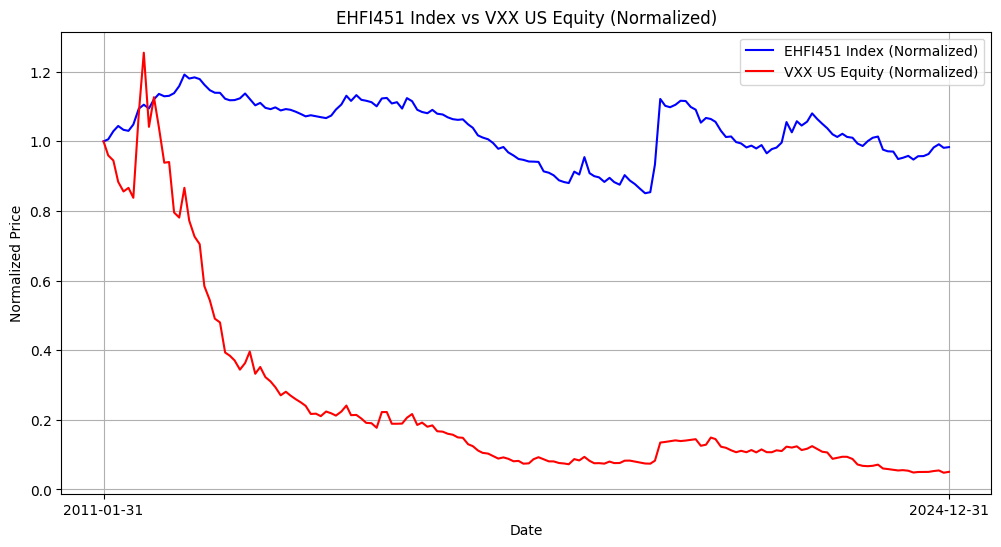

In [17]:
# 1. Ensure Dates are properly formatted
volatility_monthly['Dates'] = pd.to_datetime(volatility_monthly['Dates'], dayfirst=True)
volatility_monthly = volatility_monthly.sort_values(by='Dates')

best_proxy = 'VIXM US Equity'

# 2. Keep only relevant columns: benchmaEHFI451 Index) and best proxy (SPY US Equity)
volatility_monthly_filtered = volatility_monthly[['Dates', 'EHFI451 Index', best_proxy]].dropna()

# 3. Compute daily returns for both columns
volatility_monthly_returns = volatility_monthly_filtered.set_index('Dates').pct_change().dropna()

# 4. Assign dependent variable (benchmark) and independent variables (proxy)
y = volatility_monthly_returns['EHFI451 Index']  # Benchmark returns
X = volatility_monthly_returns[best_proxy]  # Best proxy returns

# 5. Add constant (intercept) to the independent variable
X_const = sm.add_constant(X)

# 6. Fit the regression model
model = sm.OLS(y, X_const).fit()

# 7. Print regression summary
print(model.summary())

# 8. Normalize prices for visualization (adjust to common scale)
volatility_monthly_filtered[['EHFI451 Index', best_proxy]] = volatility_monthly_filtered[['EHFI451 Index', best_proxy]].apply(lambda x: x / x.iloc[0])

# 9. Plot normalized prices over time
plt.figure(figsize=(12, 6))
plt.plot(volatility_monthly_filtered['Dates'], volatility_monthly_filtered['EHFI451 Index'], label="EHFI451 Index (Normalized)", color='blue')
plt.plot(volatility_monthly_filtered['Dates'], volatility_monthly_filtered[best_proxy], label="VXX US Equity (Normalized)", color='red')

# Simplify x-axis: show only first and last date
plt.xticks([volatility_monthly_filtered['Dates'].iloc[0], volatility_monthly_filtered['Dates'].iloc[-1]], rotation=0)
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.title("EHFI451 Index vs VXX US Equity (Normalized)")
plt.legend()
plt.grid()
plt.show()

In [18]:
vix.head()

,Dates,VIX
2,2001-01-02,29.989999771118164
3,2001-01-03,26.600000381469727
4,2001-01-04,26.969999313354492
5,2001-01-05,28.670000076293945
6,2001-01-08,29.84000015258789
